In [4]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00


In [ ]:
import os
import time
import string
from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn_crfsuite.metrics import flat_f1_score
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [ ]:
def load_data(file_path):
    sentences, labels = [], []
    sentence, label = [], []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() == "":  # Dòng trắng: Kết thúc câu
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                parts = line.strip().split()
                if len(parts) != 5:  # Kiểm tra định dạng
                    continue
                word, pos, chunk, ner_label, nested_ner = parts
                sentence.append((word, pos, chunk, ner_label, nested_ner))
                label.append(ner_label)  # Dùng nhãn NER chính

    return sentences, labels


In [ ]:
def extract_features(sentence):
    """Trích xuất đặc trưng từ mỗi từ trong câu."""
    features = []
    for i, (word, pos, chunk, ner, nested_ner) in enumerate(sentence):
        feature_dict = {
            "word": word,
            "lowercase": word.lower(),
            "is_upper": word.isupper(),
            "is_title": word.istitle(),
            "is_digit": word.isdigit(),
            "suffix-3": word[-3:],  # 3 ký tự cuối
            "prefix-3": word[:3],  # 3 ký tự đầu
            "pos": pos,  # Gắn thêm POS
            "chunk": chunk,  # Gắn thêm thông tin Chunking
            "nested_entity": nested_ner,  # Có thể dùng nếu huấn luyện Nested NER
            "prev_word": sentence[i - 1][0] if i > 0 else "<START>",
            "prev_pos": sentence[i - 1][1] if i > 0 else "<START>",
            "prev_chunk": sentence[i - 1][2] if i > 0 else "<START>",
            "next_word": sentence[i + 1][0] if i < len(sentence) - 1 else "<END>",
            "next_pos": sentence[i + 1][1] if i < len(sentence) - 1 else "<END>",
            "next_chunk": sentence[i + 1][2] if i < len(sentence) - 1 else "<END>",
        }
        features.append(feature_dict)
    return features


In [ ]:
# Load dữ liệu
train_sentences, train_labels = load_data("/content/train_data.txt")
test_sentences, test_labels = load_data("/content/test_data.txt")

# Chuyển câu thành đặc trưng
X_train = [extract_features(s) for s in train_sentences]
X_test = [extract_features(s) for s in test_sentences]


In [ ]:
import joblib  # Thư viện để lưu mô hình

# Danh sách số lần lặp thử nghiệm
max_iterations_list = [5, 10, 15, 20, 30, 35, 40, 45, 50, 55, 60]

train_f1_scores = []
test_f1_scores = []
best_f1 = 0.0  # Lưu giá trị F1 tốt nhất
best_model = None  # Lưu mô hình tốt nhất

for max_iter in max_iterations_list:
    print(f"Training with max_iterations = {max_iter}...")

    # Khởi tạo mô hình CRF
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1, c2=2.0,
        max_iterations=max_iter,  # Thử nghiệm với các số lần lặp khác nhau
        all_possible_transitions=True
    )

    # Huấn luyện mô hình
    crf.fit(X_train, train_labels)

    # Dự đoán trên tập train và test
    y_train_pred = crf.predict(X_train)
    y_test_pred = crf.predict(X_test)

    # Đánh giá F1-score trên tập train và test
    train_f1 = metrics.flat_f1_score(train_labels, y_train_pred, average='weighted')
    test_f1 = metrics.flat_f1_score(test_labels, y_test_pred, average='weighted')

    print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")

    # Lưu kết quả để vẽ đồ thị
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

    # Kiểm tra xem đây có phải là mô hình tốt nhất không
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_model = crf  # Lưu lại mô hình có test F1-score cao nhất
        joblib.dump(crf, "best_crf_model.pkl")  # Lưu checkpoint
        print(f"✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = {best_f1:.4f}")

# Hiển thị kết quả cuối cùng
print(f"\n🎯 Mô hình tốt nhất có test F1-score = {best_f1:.4f}, đã được lưu vào 'best_crf_model.pkl'")

Training with max_iterations = 5...
Train F1-score: 0.8116, Test F1-score: 0.7760
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.7760
Training with max_iterations = 10...
Train F1-score: 0.8951, Test F1-score: 0.8601
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.8601
Training with max_iterations = 15...
Train F1-score: 0.9413, Test F1-score: 0.9169
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.9169
Training with max_iterations = 20...
Train F1-score: 0.9667, Test F1-score: 0.9547
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.9547
Training with max_iterations = 30...
Train F1-score: 0.9909, Test F1-score: 0.9874
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.9874
Training with max_iterations = 35...
Train F1-score: 0.9950, Test F1-score: 0.9925
✅ Lưu checkpoint - Mô hình tốt nhất với test F1-score = 0.9925
Training with max_iterations = 40...
Train F1-score: 0.9968, Test F1-score: 0.9947
✅ Lưu checkpoint - Mô hình tốt nhất với te

In [ ]:
# Load mô hình tốt nhất từ file checkpoint
best_model = joblib.load("best_crf_model.pkl")

# Dự đoán trên dữ liệu mới
y_pred = best_model.predict(X_test)

# Đánh giá lại mô hình
print(metrics.flat_classification_report(test_labels, y_pred))


              precision    recall  f1-score   support

        B-CQ       1.00      0.99      1.00      7105
        B-NG       1.00      1.00      1.00      4087
        B-SL       1.00      0.98      0.99       750
      B-VBPL       0.96      0.95      0.95       857
        B-ĐT       0.99      0.98      0.99      7109
        I-CQ       0.99      0.99      0.99      2402
        I-NG       1.00      1.00      1.00      4087
        I-SL       0.99      0.98      0.98       767
      I-VBPL       0.96      0.98      0.97      2997
        I-ĐT       0.98      0.95      0.97      6031
           O       1.00      1.00      1.00    199407

    accuracy                           1.00    235599
   macro avg       0.99      0.98      0.98    235599
weighted avg       1.00      1.00      1.00    235599



In [ ]:
!pip install seaborn matplotlib


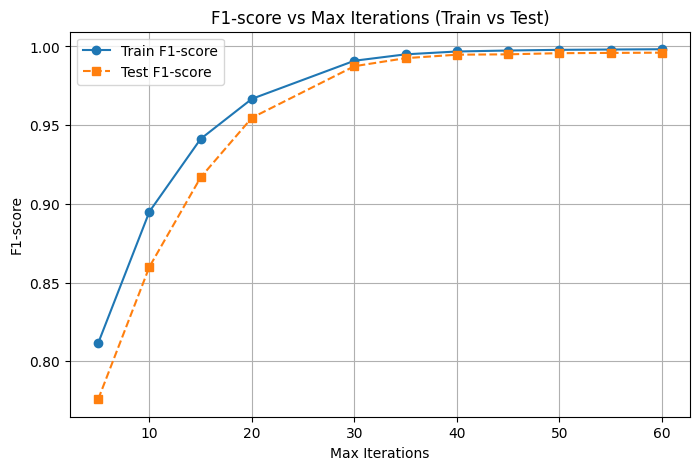

In [ ]:
# Vẽ biểu đồ F1-score của tập train và test theo số lần lặp (max_iterations)
plt.figure(figsize=(8, 5))
plt.plot(max_iterations_list, train_f1_scores, marker='o', linestyle='-', label="Train F1-score")
plt.plot(max_iterations_list, test_f1_scores, marker='s', linestyle='--', label="Test F1-score")

# Định dạng biểu đồ
plt.xlabel("Max Iterations")
plt.ylabel("F1-score")
plt.title("F1-score vs Max Iterations (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn_crfsuite import metrics
print(metrics.flat_classification_report(test_labels, y_test_pred))

              precision    recall  f1-score   support

        B-CQ       0.99      0.97      0.98      7105
        B-NG       1.00      0.99      1.00      4087
        B-SL       0.99      0.97      0.98       750
      B-VBPL       0.95      0.93      0.94       857
        B-ĐT       0.98      0.92      0.94      7109
        I-CQ       0.92      0.94      0.93      2402
        I-NG       1.00      0.99      1.00      4087
        I-SL       0.99      0.97      0.98       767
      I-VBPL       0.95      0.97      0.96      2997
        I-ĐT       0.92      0.83      0.88      6031
           O       0.99      1.00      0.99    199407

    accuracy                           0.99    235599
   macro avg       0.97      0.95      0.96    235599
weighted avg       0.99      0.99      0.99    235599



In [ ]:
from collections import Counter

label_counts = Counter(label for sentence in train_labels for label in sentence)
print("Phân phối nhãn trong tập huấn luyện:", label_counts)


Phân phối nhãn trong tập huấn luyện: Counter({'O': 2260705, 'I-VBPL': 56802, 'B-CQ': 52509, 'B-ĐT': 51555, 'I-ĐT': 36852, 'I-NG': 27975, 'B-NG': 27954, 'I-SL': 23454, 'B-SL': 22500, 'B-VBPL': 17682, 'I-CQ': 16128})


In [2]:
!pip install joblib

In [ ]:
import joblib

# Lưu mô hình vào file
joblib.dump(crf, "crf_model.pkl")

print("Mô hình đã được lưu thành công!")


In [ ]:
import joblib
# Tải mô hình đã lưu
loaded_crf = joblib.load("/content/crf_model.pkl")

# Kiểm tra dự đoán với mô hình đã tải
y_pred = loaded_crf.predict(X_test)

# In báo cáo đánh giá
from sklearn_crfsuite import metrics
print(metrics.flat_classification_report(test_labels, y_pred))


## model cũ

In [6]:
import pickle
# Load mô hình CRF đã huấn luyện
with open("/content/crf_model.pkl", "rb") as f:
    crf = pickle.load(f)


In [13]:
new_sentence = ["Trực_tuyến", "5", "Ngày", "Công_bố", "thông_tin", "trên", "trang", "thông_tin", "điện_tử", "Luật", "64/2006/QH11", "-", "Phòng", ",", "chống", "nhiễm", "vi_rút", "gây", "ra", "hội_chứng", "suy_giảm", "miễn_dịch", "mắc", "phải", "ở", "người", "HIV/AIDS", "nghị_định", "90/2016/NĐ-CP", "-", "nghị_định", "90/2016/NĐ-CP" ]


In [14]:
def extract_features(sentence):
    return [{"word": word} for word in sentence]  # Chỉ dùng đặc trưng từ

# Chuyển câu thành đặc trưng
X_new = [extract_features(new_sentence)]


In [15]:
# Dự đoán nhãn thực thể
y_pred = crf.predict(X_new)

# Kết quả dự đoán
for word, label in zip(new_sentence, y_pred[0]):
    print(f"{word}: {label}")


Trực_tuyến: I-CQ
5: I-CQ
Ngày: I-CQ
Công_bố: I-CQ
thông_tin: I-CQ
trên: I-CQ
trang: I-CQ
thông_tin: I-CQ
điện_tử: I-CQ
Luật: I-CQ
64/2006/QH11: I-CQ
-: I-CQ
Phòng: I-CQ
,: I-CQ
chống: I-CQ
nhiễm: I-CQ
vi_rút: I-CQ
gây: I-CQ
ra: I-CQ
hội_chứng: I-CQ
suy_giảm: I-CQ
miễn_dịch: I-CQ
mắc: I-CQ
phải: I-CQ
ở: I-CQ
người: I-CQ
HIV/AIDS: I-CQ
nghị_định: I-CQ
90/2016/NĐ-CP: I-CQ
-: I-CQ
nghị_định: I-CQ
90/2016/NĐ-CP: I-CQ
